# Part 3: Compression

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Fetch the jet tagging dataset from Open ML

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

## Now construct a model
We'll use the same architecture as in part 1: 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [4]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train sparse
This time we'll use the Tensorflow model optimization sparsity to train a sparse model (forcing many weights to '0'). In this instance, the target sparsity is 75%

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [8]:
# Set train = False to load the trained model rather than training again.
train = True

if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_2')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_2/KERAS_check_best_model.h5')

else:
    from tensorflow.keras.models import load_model
    model = load_model('model_2/KERAS_check_best_model.h5')

Epoch 1/30
481/487 [============================>.] - ETA: 0s - loss: 1.0693 - accuracy: 0.6640
***callbacks***
saving losses to model_2/losses.log

Epoch 00001: val_loss improved from inf to 1.00565, saving model to model_2/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.00565, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_2/KERAS_check_model_last.h5

Epoch 00001: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 8ms/step - loss: 1.0686 - accuracy: 0.6643 - val_loss: 1.0057 - val_accuracy: 0.6941 - lr: 1.0000e-04
Epoch 2/30
487/487 [==============================] - ETA: 0s - loss: 0.9587 - accuracy: 0.7045
***callbacks***
saving losses to model_2/losses.log

Epoch 00002: val_loss improved from 1.00565 to 0.92510, saving model to model_2/KERAS_check_best_model.h5

Epoch 00002: val_loss improved from 1.00565 to 0.92510, saving model to mode

Epoch 14/30
487/487 [==============================] - ETA: 0s - loss: 0.8079 - accuracy: 0.7305
***callbacks***
saving losses to model_2/losses.log

Epoch 00014: val_loss improved from 0.81417 to 0.81041, saving model to model_2/KERAS_check_best_model.h5

Epoch 00014: val_loss improved from 0.81417 to 0.81041, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00014: saving model to model_2/KERAS_check_model_last.h5

Epoch 00014: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 8ms/step - loss: 0.8079 - accuracy: 0.7305 - val_loss: 0.8104 - val_accuracy: 0.7305 - lr: 1.0000e-04
Epoch 15/30
484/487 [============================>.] - ETA: 0s - loss: 0.8042 - accuracy: 0.7314
***callbacks***
saving losses to model_2/losses.log

Epoch 00015: val_loss improved from 0.81041 to 0.80681, saving model to model_2/KERAS_check_best_model.h5

Epoch 00015: val_loss improved from 0.81041 to 0.80681, saving mod

486/487 [============================>.] - ETA: 0s - loss: 0.7719 - accuracy: 0.7400
***callbacks***
saving losses to model_2/losses.log

Epoch 00026: val_loss improved from 0.77770 to 0.77538, saving model to model_2/KERAS_check_best_model.h5

Epoch 00026: val_loss improved from 0.77770 to 0.77538, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00026: saving model to model_2/KERAS_check_model_last.h5

Epoch 00026: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 8ms/step - loss: 0.7720 - accuracy: 0.7400 - val_loss: 0.7754 - val_accuracy: 0.7395 - lr: 1.0000e-04
Epoch 27/30
482/487 [============================>.] - ETA: 0s - loss: 0.7698 - accuracy: 0.7406
***callbacks***
saving losses to model_2/losses.log

Epoch 00027: val_loss improved from 0.77538 to 0.77331, saving model to model_2/KERAS_check_best_model.h5

Epoch 00027: val_loss improved from 0.77538 to 0.77331, saving model to model_

TypeError: unhashable type: 'ListWrapper'

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

[]

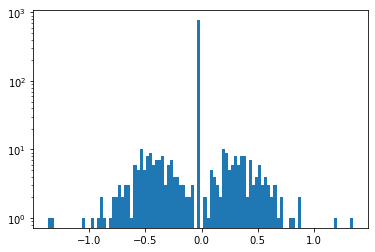

In [9]:
h, b = np.histogram(model.layers[0].weights[0].numpy(), bins=100)
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()

## Check performance
How does this 75% sparse model compare against the unpruned model? Let's report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.
**Make sure you've trained the model from part 1**

Accuracy pruned:   0.7402409638554217
Accuracy unpruned: 0.7507469879518073


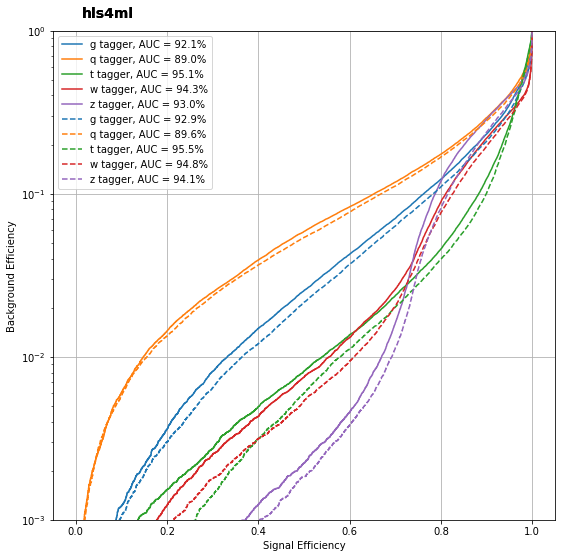

In [10]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#Load model and calculate the pruned and unpruned models' accuracy.
model_ref = load_model('model_1/KERAS_check_best_model.h5')
print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))))
print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(model_ref.predict(X_test), axis=1))))

#Plot the ROC curve again
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(X_test, y_test, le.classes_, model)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(X_test, y_test, le.classes_, model_ref, linestyle='--')

# Convert the model to FPGA firmware with hls4ml
Let's use the default configuration: `ap_fixed<16,6>` precision everywhere and `ReuseFactor=1`, so we can compare with the part 1 model. We need to use `strip_pruning` to change the layer types back to their originals.
**The synthesis will take a while**

In [12]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, output_dir='model_2/hls4ml_prj')
hls_model.compile()
hls_model.build(synth=True)

Interpreting Sequential
Topology:


Exception: ERROR: Unsupported layer type: PruneLowMagnitude

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [ ]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj/')

Print the report for the model trained in part 1. Remember these models have the same architecture, but the model in this section was trained using the sparsity API from tensorflow_model_optimization. Notice how the resource usage had dramatically reduced (particularly the DSPs). When Vivado HLS notices an operation like `y = 0 * x` it can avoid placing a DSP for that operation. The impact of this is biggest when `ReuseFactor = 1`, but still applies at higher reuse as well. **Note you need to have trained and synthesized the model from part 1**

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')